Notebook by Jacqueline Lam

In [4]:
!pip install evaluate accelerate
!pip install --upgrade transformers
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from datasets.dataset_dict import DatasetDict
from datasets import Dataset, load_dataset

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
import evaluate

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


##Data Prep

In [6]:
# dataset = load_dataset("quotaclimat/frugalaichallenge-text-train")
# print(next(iter(dataset['train'])))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.80k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.02M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/248k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1219 [00:00<?, ? examples/s]

{'quote': 'Interesting to note that Oklahoma minimum temperatures in 2011 were in the bottom ten, including the coldest Oklahoma temperature ever recorded, -31F on February 10, 2011.', 'label': '0_not_relevant', 'source': 'FLICC', 'url': 'https://huggingface.co/datasets/fzanartu/FLICCdataset', 'language': 'en', 'subsource': 'CARDS', 'id': None, '__index_level_0__': 1109}


In [35]:
# dataset['test'][0]

{'quote': 'Mann could be said to be the Jerry Sandusky of climate science, except for instead of molesting children, he has molested and tortured data in the service of politicized science that could have dire economic consequences for the nation and planet,” Rand Simberg wrote in\xa0National Review\xa0article in\xa02012.',
 'label': '6_proponents_biased',
 'source': 'Desmog',
 'url': 'https://www.desmog.com/judith-curry/',
 'language': 'en',
 'subsource': None,
 'id': None,
 '__index_level_0__': 6050}

In [10]:
df = pd.read_csv('/content/drive/MyDrive/frugal_ai/Juliana/df_limited.csv')
df = df.rename(columns={"label": "label_full", "quote": "text"})
df.head()

,text,label_full,connection_index,type,set
0,"I, I’m not sure why, uh, people have tried to ...",0_not_relevant,1938,oga,train
1,"Seldom, if ever, in Canadian history has so mu...",0_not_relevant,2975,oga,test
2,What do you think? I’d say [I’ve been] a small...,0_not_relevant,6085,oga,test
3,"Really, given that God does judge nations, it’...",0_not_relevant,3212,oga,train
4,"And then he met Meghan Markle, and it’s fallen...",0_not_relevant,5405,oga,train


In [11]:
id2label = {
    0: "0_not_relevant",
    1: "1_not_happening",
    2: "2_not_human",
    3: "3_not_bad",
    4: "4_solutions_harmful_unnecessary",
    5: "5_science_unreliable",
    6: "6_proponents_biased",
    7: "7_fossil_fuels_needed"
}

label2id = {
    "0_not_relevant": 0,
    "1_not_happening": 1,
    "2_not_human": 2,
    "3_not_bad": 3,
    "4_solutions_harmful_unnecessary": 4,
    "5_science_unreliable": 5,
    "6_proponents_biased": 6,
    "7_fossil_fuels_needed": 7
}

In [12]:
df['label'] = df['label_full'].map(label2id)
df.label = df.label.astype(int)
df.head()

,text,label_full,connection_index,type,set,label
0,"I, I’m not sure why, uh, people have tried to ...",0_not_relevant,1938,oga,train,0
1,"Seldom, if ever, in Canadian history has so mu...",0_not_relevant,2975,oga,test,0
2,What do you think? I’d say [I’ve been] a small...,0_not_relevant,6085,oga,test,0
3,"Really, given that God does judge nations, it’...",0_not_relevant,3212,oga,train,0
4,"And then he met Meghan Markle, and it’s fallen...",0_not_relevant,5405,oga,train,0


In [18]:
train_df = df[df['set'] == 'train'][["label", "text"]]
test_df = df[df['set'] == 'test'][["label", "text"]]

In [19]:
# train_df = df.loc[df['set'=='train']][["label", "text"]]
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=123)

train_df.shape, test_df.shape, val_df.shape

((3239, 2), (945, 2), (360, 2))

In [20]:
d = {'train':Dataset.from_dict(train_df[["label", "text"]]),
     'test':Dataset.from_dict(test_df[["label", "text"]]),
     'val':Dataset.from_dict(val_df[["label", "text"]])
     }

dataset_dict = DatasetDict(d)

##Finetuning

In [21]:
tokenizer = AutoTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [22]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [23]:
tokenized_data = dataset_dict.map(preprocess_function, batched=True)

Map:   0%|          | 0/3239 [00:00<?, ? examples/s]

Map:   0%|          | 0/945 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [24]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [25]:
accuracy = evaluate.load("accuracy")

In [26]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [36]:
model = AutoModelForSequenceClassification.from_pretrained(
    'roberta-base', num_labels=8, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Freeze the first n layers of the encoder
for param in model.base_model.encoder.layer[:8].parameters():
    param.requires_grad = False

# Unfreeze the last few layers for fine-tuning
for param in model.base_model.encoder.layer[4:].parameters():
    param.requires_grad = True

In [38]:
training_args = TrainingArguments(
    output_dir="frugal_ai/finetune_RoBERTa",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["val"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.866914,0.697222
2,No log,0.835699,0.700000
3,0.994200,0.721633,0.750000
4,0.994200,0.822021,0.750000
5,0.345500,0.995382,0.722222
6,0.345500,1.100101,0.780556
7,0.345500,1.325483,0.738889
8,0.097000,1.341054,0.763889
9,0.097000,1.593961,0.758333
10,0.043900,1.709079,0.761111


TrainOutput(global_step=10150, training_loss=0.0784985595263926, metrics={'train_runtime': 1332.1214, 'train_samples_per_second': 121.573, 'train_steps_per_second': 7.619, 'total_flos': 1.5276276870523296e+16, 'train_loss': 0.0784985595263926, 'epoch': 50.0})

##Inference

In [30]:
def infer_model(text, tokenizer, model, id2label):

  inputs = tokenizer(text, return_tensors="pt").input_ids.to(0)

  with torch.no_grad():
    # model.to('cuda')
    logits = model(inputs).logits

  predicted_class_id = logits.argmax().item()
  result = model.config.id2label[predicted_class_id]
  return result

In [39]:
labels = test_df['label'].map(id2label)
pred_labels = []

tokenizer_tuned = AutoTokenizer.from_pretrained("jacq-is/finetune_RoBERTa")
model_tuned = AutoModelForSequenceClassification.from_pretrained("jacq-is/finetune_RoBERTa").to(0)

for i in range(len(dataset_dict['test'])):
  pred_labels.append(infer_model(dataset_dict['test'][i]['text'], tokenizer_tuned, model_tuned, id2label))

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [40]:
#result
print(np.unique(labels))
print(np.unique(pred_labels))

['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']
['0_not_relevant' '1_not_happening' '2_not_human' '3_not_bad'
 '4_solutions_harmful_unnecessary' '5_science_unreliable'
 '6_proponents_biased' '7_fossil_fuels_needed']


Text(50.5815972222222, 0.5, 'True')

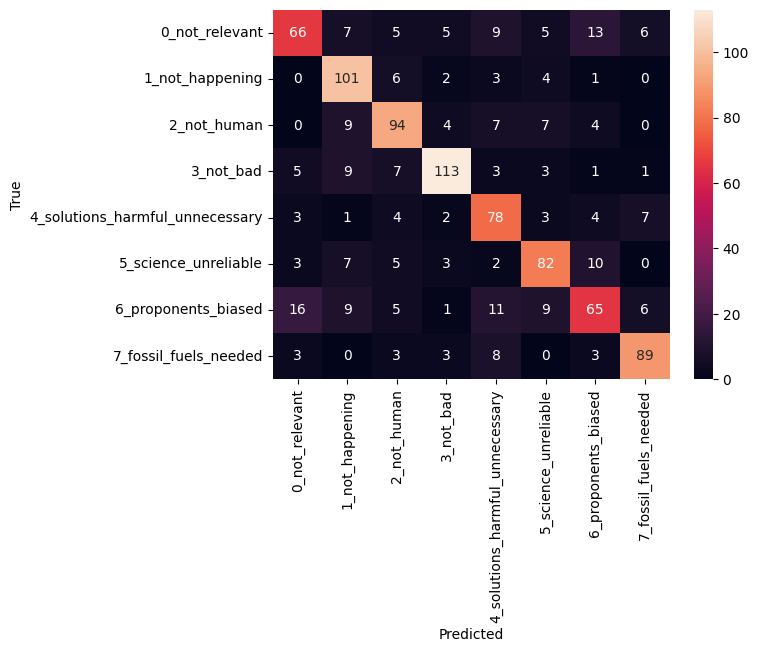

In [41]:
names=np.unique(labels)
cm = confusion_matrix(labels, pred_labels, labels=names)
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=names,
    yticklabels=names)
plt.xlabel("Predicted")
plt.ylabel("True")

In [42]:
print(classification_report(labels, pred_labels, target_names=names, digits=4))

                                 precision    recall  f1-score   support

                 0_not_relevant     0.6875    0.5690    0.6226       116
                1_not_happening     0.7063    0.8632    0.7769       117
                    2_not_human     0.7287    0.7520    0.7402       125
                      3_not_bad     0.8496    0.7958    0.8218       142
4_solutions_harmful_unnecessary     0.6446    0.7647    0.6996       102
           5_science_unreliable     0.7257    0.7321    0.7289       112
            6_proponents_biased     0.6436    0.5328    0.5830       122
          7_fossil_fuels_needed     0.8165    0.8165    0.8165       109

                       accuracy                         0.7280       945
                      macro avg     0.7253    0.7283    0.7237       945
                   weighted avg     0.7287    0.7280    0.7253       945

